In [234]:
import socket
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import time

In [225]:
image = []

with open("umdlogo.jpg", "rb") as jpg:
    
    while True:
        image = jpg.read()
        break

In [226]:
def strToBin(msg: str):
    binRep = ""

    for character in msg:
        binRep += f"{(ord(character)):08b}"

    return binRep

In [227]:
def separateData(packet):
    stringPacket = [f"{packByte:08b}" for packByte in packet]
    flags = stringPacket[0]
    seqNum = int("".join(stringPacket[1:5]), base = 2)
    ackNum = int("".join(stringPacket[5:9]), base = 2)
    payloadSize = int("".join(stringPacket[9:11]), base = 2)
    payload = "".join(stringPacket[11:-1])[-payloadSize:]
    return (flags, seqNum, ackNum, payload)


In [228]:
def getCRC(binCode, divisor):
    payload = list(binCode) + ([0]*(len(divisor)-1))
    payload = [int(n) for n in payload]
    divisor = [int(n) for n in list(divisor)]
    remainder = []
    pointer = 0

    while pointer <= len(payload) - len(divisor):
        #Extract slice to subtract
        val = payload[pointer: pointer + len(divisor)]
        
        #Subtract paired values
        operations = zip(val, divisor)
        remainder = [abs(op[0] - op[1]) for op in operations]
        
        #Modify payload values, set pointer to index
        for i in range(len(divisor)):
            payload[pointer + i] = remainder[i]
        
        #Move pointer to next non-zero value
        if 1 not in payload:
            return "0"*(len(divisor)-1)
        pointer = payload.index(1)

    return "".join([str(val) for val in payload[-(len(divisor) - 1):]])

In [229]:
def checkCRC(binCode, divisor):
    stringPacket = [f"{packByte:08b}" for packByte in binCode]
    payload = []
    for byteSection in stringPacket:
        payload += byteSection
    payload = [int(n) for n in payload]
    divisor = [int(n) for n in list(divisor)]
    remainder = []
    pointer = 0

    while pointer <= len(payload) - len(divisor):
        #Extract slice to subtract
        val = payload[pointer: pointer + len(divisor)]
        
        #Subtract paired values
        operations = zip(val, divisor)
        remainder = [abs(op[0] - op[1]) for op in operations]
        
        #Modify payload values, set pointer to index
        for i in range(len(divisor)):
            payload[pointer + i] = remainder[i]
        
        #Move pointer to next non-zero value
        if 1 not in payload:
            return 0
        pointer = payload.index(1)

    return "".join([str(val) for val in payload[-(len(divisor) - 1):]])

In [230]:
def buildPacket(sync = 0, ack = 0, fin = 0, seqNum = 0, ackNum = 0, payload = 0, payloadSize = 0, divisor = "000000000"):
    flags = f"000{ack}00{sync}{fin}"
    stringPacket = flags + f"{seqNum:032b}" + f"{ackNum:032b}" + f"{payloadSize:016b}" + f"{payload:01024b}"
    CRC = ""
    if int(divisor) > 0:
        CRC = getCRC(stringPacket, divisor)

    else:
        CRC = "00000000"
    stringPacket += CRC
    
    listPacket = np.array([val for val in stringPacket]).reshape(int(np.ceil(len(stringPacket)/8)),8)
    intPacket = [int("".join(listByte), base = 2) for listByte in listPacket]

    return intPacket

In [231]:
def imageToBin(image):
    stringPacket = [f"{packByte:08b}" for packByte in image]
    return "".join(stringPacket)
    

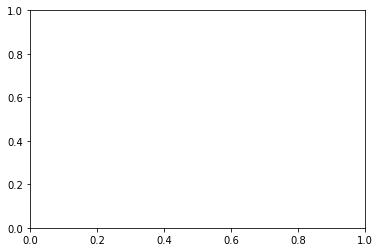

In [245]:
axes = []
def prepAnim(i):
    graph_data = open('latency.txt','r').read()
    lines = graph_data.split('\n')
    xs = []
    ys = []
    for line in lines:
        if len(line) > 1:
            x, y = line.split(',')
            xs.append(float(x))
            ys.append(float(y))
    axes[0].clear()
    axes[0].plot(xs, ys)

def Anim():
    fig = plt.figure()
    axes.append(fig.add_subplot(1,1,1))
    ani = animation.FuncAnimation(fig, prepAnim, interval=1000)
    plt.show()

# Logs
latencyFile = open("latency.txt", "w").close()
Anim()

In [246]:
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    try:
        s.bind(("localhost", 8088))
        s.connect(("localhost", 8000))
        # msg_send = input("Enter a message")
        # msgBin = strToBin(msg_send)
        msgBin = imageToBin(image)

        # Define some packet info
        seqNum = 0
        ackNum = 0
        divisor = '100000111'



        print(f"Connected to 127")

        # Handshake
        # - Send Sync Request
        syncPacket = bytes(buildPacket(sync=1))
        sent = s.send(syncPacket)

        # - Receive Sync Ack
        ackPacket = s.recv(2048)
        flags, otherSeq, otherAck, otherPayload = separateData(ackPacket)
        ackNum = otherAck
        print("Server Acknowledged: ",otherAck)

        # - Send Sync Ack
        ackPacket = bytes(buildPacket(ack=1, ackNum=ackNum, seqNum=seqNum))
        seqNum += 1
        payloadSent = 0
        sent = s.send(ackPacket)
        cnt = 1
        history = ""

        while True:

            # Send Data
            print("sending payload")
            payloadSlice = msgBin[payloadSent: payloadSent + 1024]
            if len(payloadSlice):
                payloadPiece = bytes(buildPacket(ackNum=ackNum, seqNum=seqNum, payloadSize= len(payloadSlice), payload=int(payloadSlice, base=2), divisor=divisor))
            else:
                payloadPiece = bytes(buildPacket(ackNum=ackNum, seqNum=seqNum, divisor=divisor))

            ttr = time.monotonic()
            sent = s.send(payloadPiece)

            # Wait for acknowledgement
            print("waiting for ack")
            resp = s.recv(2048)
            ttr = time.monotonic() - ttr

            flags, otherSeq, otherAck, otherPayload = separateData(resp)

            if otherAck == seqNum + len(payloadPiece):
                print("Sequence Num", seqNum,"-->",seqNum + len(payloadPiece))
                seqNum += len(payloadPiece)
                payloadSent += 1024

            else:
                print("Faulty checksum")
                print(checkCRC(payloadPiece, divisor))


            if seqNum >= len(msgBin) + (98 * cnt) or cnt > 700:
                print("Finished sending data")
                s.send(bytes(buildPacket(fin = 1, divisor=divisor)))
                s.close()
                break

            cnt += 1
            

            # time.sleep(3)
            lF = open("latency.txt", "a")
            lF.write(f"{cnt},{ttr}\n")
            lF.close()

        s.close()
        
    except Exception as error:
        s.close()
        raise error


Connected to 127
Server Acknowledged:  1
sending payload
waiting for ack
Sequence Num 1 --> 141
sending payload
waiting for ack
Sequence Num 141 --> 281
sending payload
waiting for ack
Sequence Num 281 --> 421
sending payload
waiting for ack
Sequence Num 421 --> 561
sending payload
waiting for ack
Sequence Num 561 --> 701
sending payload
waiting for ack
Sequence Num 701 --> 841
sending payload
waiting for ack
Sequence Num 841 --> 981
sending payload
waiting for ack
Sequence Num 981 --> 1121
sending payload
waiting for ack
Sequence Num 1121 --> 1261
sending payload
waiting for ack
Sequence Num 1261 --> 1401
sending payload
waiting for ack
Sequence Num 1401 --> 1541
sending payload
waiting for ack
Sequence Num 1541 --> 1681
sending payload
waiting for ack
Sequence Num 1681 --> 1821
sending payload
waiting for ack
Sequence Num 1821 --> 1961
sending payload
waiting for ack
Faulty checksum
0
sending payload
waiting for ack
Sequence Num 1961 --> 2101
sending payload
waiting for ack
Sequence 

KeyboardInterrupt: 